<a href="https://colab.research.google.com/github/Nimish-4/Stock_price_prediction_LSTM/blob/main/Stock_price_prediction_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this Colab file, we will use a keras Long Short-Term Memory (LSTM) model to predict the stock price of MARUTI from BSE


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf

Load training data set with the "Close" columns to use in our modeling.

In [ ]:
#dataset_train = pd.read_csv(url)
data =  yf.download('MARUTI.BO', start='2012-01-01', end='2018-01-01')
training_set = data['Close'].values
training_set=training_set.reshape(-1,1)
training_set.shape

[*********************100%***********************]  1 of 1 completed


(1477, 1)

Let's take a look at the first five rows of our dataset

In [ ]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-02,930.0,943.900024,916.849976,936.799988,853.327148,99296
2012-01-03,944.0,964.000000,943.000000,952.500000,867.628296,49020
2012-01-04,950.0,968.500000,943.000000,948.400024,863.893616,41626
2012-01-05,948.0,948.000000,927.099976,932.700012,849.592529,77189
2012-01-06,933.0,955.000000,927.549988,949.150024,864.576782,62258


Import MinMaxScaler from scikit-learn to scale our dataset into numbers between 0 and 1

In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

We want our data to be in the form of a 3D array for our LSTM model. First, we create data in 60 timesteps and convert it into an array using NumPy. Then, we convert the data into a 3D array with X_train samples, 60 timestamps, and one feature at each step.

In [ ]:
X_train = []
y_train = []
for i in range(60, data.shape[0]):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(1417, 60, 1)

Make the necessary imports from keras

In [ ]:
from keras.models import Model
from keras.layers import LSTM, Dense, Dropout, AdditiveAttention, Permute, Reshape, Multiply, Input, Flatten, BatchNormalization

Add LSTM layer along with dropout layers to prevent overfitting. After that, we add a Dense layer that specifies a one unit output. Next, we compile the model using the adam optimizer and set the loss as the mean_squarred_error

In [ ]:
inputs = Input(shape=(X_train.shape[1], 1))

# Adding LSTM layers with Dropout and Batch Normalization
x = LSTM(units=50, return_sequences=True)(inputs)
x = BatchNormalization()(x)  # Batch Normalization after LSTM
x = Dropout(0.2)(x)  # Dropout after Batch Normalization

x = LSTM(units=50, return_sequences=True)(x)
x = BatchNormalization()(x)  # Batch Normalization after LSTM
x = Dropout(0.2)(x)  # Dropout after Batch Normalization


x_permute = Permute((2, 1))(x)
x_reshape = Reshape((-1, X_train.shape[1]))(x_permute)

# Additive attention mechanism
attention = AdditiveAttention(name='attention_weight')([x_reshape, x_reshape])
multiply_layer = Multiply()([x_reshape, attention])

# Return to original shape
x = Permute((2, 1))(multiply_layer)
x = Reshape((-1, 50))(x)

# Flatten and add the output layer
x = Flatten()(x)
x = Dropout(0.2)(x)  # Dropout before the Dense layer
outputs = Dense(1)(x)
model = Model(inputs=inputs, outputs=outputs)


model.compile(optimizer='adam', loss='mean_squared_error',metrics=['mean_absolute_error'])
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 60, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_4 (LSTM)             │ (None, 60, 50)         │         10,400 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 60, 50)         │            200 │ lstm_4[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_6 (Dropout)       │ (None, 60, 50)         │              0 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_5 (LSTM)             │ (None, 60, 50)         │         20,200 │ dropout_6[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 60, 50)         │            200 │ lstm_5[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 60, 50)         │              0 │ batch_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ permute_4 (Permute)       │ (None, 50, 60)         │              0 │ dropout_7[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_4 (Reshape)       │ (None, 50, 60)         │              0 │ permute_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_weight          │ (None, 50, 60)         │             60 │ reshape_4[0][0],       │
│ (AdditiveAttention)       │                        │                │ reshape_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_2 (Multiply)     │ (None, 50, 60)         │              0 │ reshape_4[0][0],       │
│                           │                        │                │ attention_weight[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ permute_5 (Permute)       │ (None, 60, 50)         │              0 │ multiply_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_5 (Reshape)       │ (None, 60, 50)         │              0 │ permute_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_2 (Flatten)       │ (None, 3000)           │              0 │ reshape_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_8 (Dropout)       │ (None, 3000)           │              0 │ flatten_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1)              │          3,001 │ dropout_8[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 34,061 (133.05 KB)

 Trainable params: 33,861 (132.27 KB)

 Non-trainable params: 200 (800.00 B)

In [ ]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard, CSVLogger
from keras.callbacks import EarlyStopping


early_stopping = EarlyStopping(monitor='val_loss', patience=15)

# Callback to save the model periodically
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')

# Callback to reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)

# Callback for TensorBoard
tensorboard = TensorBoard(log_dir='./logs')

# Callback to log details to a CSV file
csv_logger = CSVLogger('training_log.csv')

# Combining all callbacks
callbacks_list = [early_stopping, model_checkpoint, reduce_lr, tensorboard, csv_logger]

# Fit the model with the callbacks
history = model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.2, callbacks=callbacks_list)

Epoch 1/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 14s 119ms/step - loss: 0.1262 - mean_absolute_error: 0.2503 - val_loss: 0.4561 - val_mean_absolute_error: 0.6615 - learning_rate: 0.0010
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 238ms/step - loss: 0.0410 - mean_absolute_error: 0.1537 - val_loss: 0.4418 - val_mean_absolute_error: 0.6506 - learning_rate: 0.0010
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 15s 117ms/step - loss: 0.0320 - mean_absolute_error: 0.1350 - val_loss: 0.4313 - val_mean_absolute_error: 0.6425 - learning_rate: 0.0010
Epoch 4/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 12s 147ms/step - loss: 0.0228 - mean_absolute_error: 0.1164 - val_loss: 0.4234 - val_mean_absolute_error: 0.6362 - learning_rate: 0.0010
Epoch 5/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 157ms/step - loss: 0.0162 - mean_absolute_error: 0.0966 - val_loss: 0.4101 - val_mean_absolute_error: 0.6258 - learning_rate: 0.0010
Epoch 6/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - loss: 0.0146 - mean_absolute_error: 0.0944 - val_loss: 0.3942 - v

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Making predictions
y_pred = model.predict(X_test)

# Calculating MAE and RMSE
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print("Mean Absolute Error: ", mae)
print("Root Mean Square Error: ", rmse)

Import the test set for the model to make predictions on

In [ ]:
data_pred = yf.download('MARUTI.BO', start='2017-08-01', end='2017-12-01')   #Predict last month of 2017, and subsequent dates
print(data_pred.tail())

#Take last 60 days of data
excess = data_pred.shape[0] - 60
data_pred = data_pred[excess:]
print(data_pred.tail())
data_pred.shape

[*********************100%***********************]  1 of 1 completed

                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2017-11-24  8475.000000  8534.000000  8475.000000  8487.700195  8041.658691   
2017-11-27  8489.650391  8514.950195  8450.000000  8506.900391  8059.849121   
2017-11-28  8507.000000  8650.000000  8491.500000  8626.200195  8172.880371   
2017-11-29  8664.000000  8695.000000  8582.000000  8668.950195  8213.383789   
2017-11-30  8661.000000  8680.000000  8581.849609  8602.299805  8150.234863   

            Volume  
Date                
2017-11-24    9492  
2017-11-27   30762  
2017-11-28   26637  
2017-11-29   10740  
2017-11-30   61266  
                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2017-11-24  8475.000000  8534.000000  8475.000000  8487.700195  8041.658691   
2017-11-27  8489.650391  8514.950195  8450.000000  8506.900391

(60, 6)

Before predicting future stock prices, we have to manipulate the training set; we merge the training set and the test set on the 0 axis, set the time step to 60, use minmaxscaler, and reshape the dataset as done previously. After making predictions, we use inverse_transform to get back the stock prices in normal readable format.


In [ ]:

predicted_values = []

X_test = data_pred['Close'].values
X_test = X_test.reshape(-1,1)
print(X_test.shape)
inputs = sc.fit_transform(X_test)
inputs = np.reshape(inputs, (-1, inputs.shape[0], 1))


num_of_days = 90
for i in range(num_of_days):

  predicted_stock_price = model.predict(inputs)
  predicted_values.append(predicted_stock_price[0])
  inputs = np.append(inputs, predicted_stock_price)
  inputs = inputs[1:]
  #inputs = sc.fit_transform(inputs)
  inputs = np.reshape(inputs, (-1, inputs.shape[0], 1))


predicted_values = sc.inverse_transform(predicted_values)
print(predicted_values)

(60, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
[[0.71644336]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[[0.7389008]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[[0.7422681]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
[[0.7299862]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[[0.736896]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
[[0.76955885]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
[[0.83561873]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[[0.91904676]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[[1.0140827]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
[[1.1004096]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
[[1.181706]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
[[1.2256883]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
[[1.2354118]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
[[1.2319576]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
[[1.2175764]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
[[1.203194]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
[[1.1856555]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
[[1.1889627]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
[[1.2119291]]
1/1

'\nn = data_pred.shape[0]\ndata_pred = data_pred.iloc[:, 1:2].values\ninputs = sc.fit_transform(data_pred)\n\nfor i in range(3,-1,-1):\n    X_test.append(inputs[n-i-60:n-i])\n    #data_pred.iloc[n-i-60:n-i].tail()\n\nX_test = np.array(X_test)\n\npredicted_stock_price = sc.inverse_transform(predicted_stock_price)\nprint(predicted_stock_price)'

Plot our predicted stock prices and the actual stock price

[*********************100%***********************]  1 of 1 completed


 2017-12-01 00:00:00 2018-05-30 00:00:00

 (90, 6)

                    Open         High          Low        Close    Adj Close  \
Date                                                                          
2018-04-11  9279.400391  9345.000000  9216.049805  9297.750000  8809.138672   
2018-04-12  9300.000000  9300.000000  9178.000000  9198.299805  8714.915039   
2018-04-13  9250.000000  9269.950195  9120.000000  9138.450195  8658.209961   
2018-04-16  9121.250000  9244.950195  9055.650391  9232.299805  8747.127930   
2018-04-17  9201.049805  9248.000000  9142.000000  9158.250000  8676.968750   

            Volume  
Date                
2018-04-11   18957  
2018-04-12   21411  
2018-04-13   15932  
2018-04-16   20518  
2018-04-17   21878  


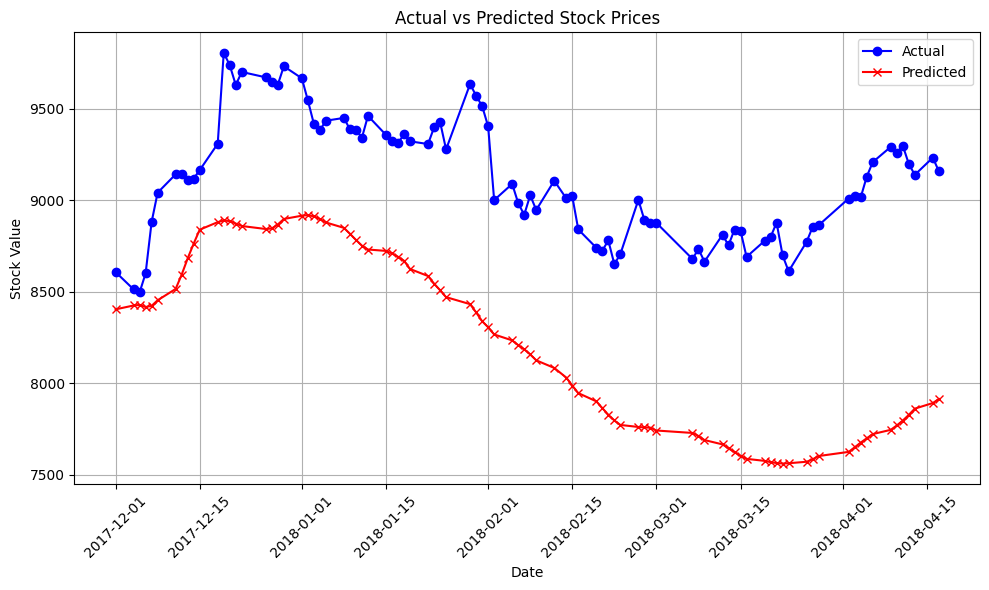

"\nplt.plot(dates,real_stock_price, color = 'black', label = 'TCS Stock Price')\nplt.plot(dates,predicted_values,dates, color = 'green', label = 'Predicted TCS Stock Price')\nplt.title('TCS Stock Price Prediction')\n#plt.yaxis(index=real_stock_price['Date'])\nplt.xlabel('Time')\nplt.ylabel('TCS Stock Price')\nplt.legend()\nplt.show()"

In [ ]:
import matplotlib.dates as mdates

start_date = data_pred.index[-1]+pd.DateOffset(days=1)
end_date = start_date + pd.DateOffset(days=num_of_days*2)
print('\n',start_date, end_date)
real_stock_price = yf.download('MARUTI.BO', start=start_date, end=end_date)
real_stock_price = real_stock_price[0:num_of_days]
print('\n',real_stock_price.shape)
print('\n',real_stock_price.tail())
dates=real_stock_price.index.values
real_stock_price =real_stock_price['Close'].values
real_stock_price =real_stock_price.reshape(-1,1)



plt.figure(figsize=(10, 6))
plt.plot(dates,real_stock_price, label='Actual', marker='o', color='blue')  # Plot actual values
plt.plot(dates, predicted_values, label='Predicted', marker='x', color='red')  # Plot predicted values

# Customizing the plot
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Stock Value')
plt.xticks(rotation=45)  # Rotate date labels for better visibility
plt.legend()  # Add legend to differentiate between actual and predicted
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

